# Store Item Demand Forecasting Challenge


In [19]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import lightgbm as lgb
from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

from src.constants import RANDOM_STATE, LGBM_MODEL_PARAMS

In [7]:
np.random.seed(RANDOM_STATE)
os.environ["PYTHONHASHSEED"] = str(RANDOM_STATE)
random.seed(RANDOM_STATE)

## Load data

In [8]:
data_raw = pd.read_csv("../data/train.csv")
data = data_raw.copy()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [15]:
data = data.set_index(pd.to_datetime(data.date).dt.to_period(freq="D")).drop(columns="date")

In [16]:
y = data["sales"]
X = data.drop(columns=["sales"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='sales'>)

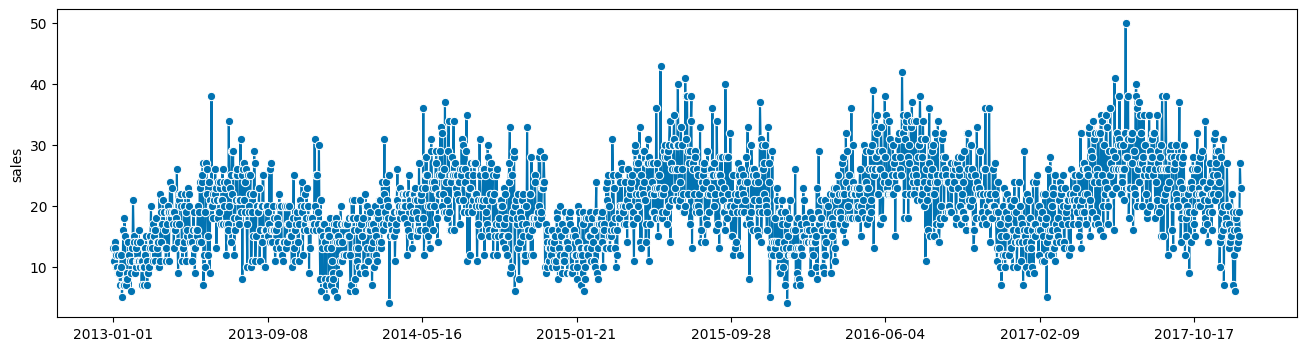

In [24]:
plot_series(y.loc[data.store.eq(1) & data.item.eq(1)])

In [26]:
X_train, X_test, y_train, y_test = temporal_train_test_split(y, X, test_size=0.3)

TypeError: y must be in an sktime compatible format, of scitype Series, Panel or Hierarchical, for instance a pandas.DataFrame with sktime compatible time indices, or with MultiIndex and last(-1) level an sktime compatible time index. Allowed compatible mtype format specifications are: ['pd.Series', 'pd.DataFrame', 'np.ndarray', 'nested_univ', 'numpy3D', 'pd-multiindex', 'df-list', 'pd_multiindex_hier']See the forecasting tutorial examples/01_forecasting.ipynb, or the data format tutorial examples/AA_datatypes_and_datasets.ipynb, If you think y is already in an sktime supported input format, run sktime.datatypes.check_raise(y, mtype) to diagnose the error, where mtype is the string of the type specification you want for y. 

## Feature engineering